In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy, sparse_top_k_categorical_accuracy
from tensorflow.keras import backend as K

from fruit_data import get_data, filelist_from_directory, create_dataset 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow_hub as hub
import cv2

from tensorflow.keras.models import save_model

# Useful functions for later

In [266]:
#Metric for defining success:
def custom_accuracy(ytrue, ypred):
    return sparse_top_k_categorical_accuracy(ytrue, ypred, k=4)

# functions for plotting learning
def plt_history(history):
    
    plt.figure(figsize=[20,6]);
    for counter, metric in enumerate(['loss', 'acc', 'custom_accuracy']):
    
        val_metric = 'val_'+metric
        plt.subplot(1,3,counter+1)
        plt.plot(history.history[metric],'r',linewidth=3.0);
        plt.plot(history.history[val_metric],'b',linewidth=3.0);
        plt.legend(['Training '+ metric, 'Validation '+metric,],fontsize=18);
        plt.xlabel('Epochs ',fontsize=16);
        plt.ylabel(metric ,fontsize=16);
        plt.title(metric +' Curves',fontsize=16);   

def resize_images(X, size=(100,100)):
    result =[]
    for counter, i in enumerate(X):
        if len(i.shape) ==3: #dont include gray scale
            i = cv2.resize(i, size, interpolation=cv2.INTER_CUBIC)
            result.append(i)
        else: 
            print(counter)
    return np.array(result)

def convert_to_supergroup(x):
    df_supergroup = pd.read_csv('./data/FruitCategories.csv')
    df_x = pd.DataFrame(x, columns=['SubCategory'])
    return (pd.merge(df_x, df_supergroup, on='SubCategory', how='left').loc[:,'Category']).values
    
    

# Load data

## training data

In [235]:
filelist = pd.read_csv('./Dataset_index/limited_training_5000_records.csv' )
X,y = create_dataset(filelist)
print('Data load complete')

Data load complete


In [236]:
label_encoder = LabelEncoder()
label_encoder.fit(y)

LabelEncoder()

In [237]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

X_train = X_train/255
X_val = X_val/255
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)


In [238]:
#128 images are used with the one model that is trained using a mobilenet feature vector
X_train128 = resize_images(X_train, size=(128,128))
X_val128 = resize_images(X_val, size=(128,128))

## test data

In [239]:
# test data is a hold out set specificly identified in the data set
filelist_test = pd.read_csv('./Dataset_index/limited_testing_1000_records.csv' )
X_test,y_test = create_dataset(filelist_test)

X_test = X_test/255
y_test = label_encoder.transform(y_test)

X_test128 = resize_images(X_test, size=(128,128))

In [240]:
#Real data has come from instagram
directory = './data/InstagramData/'

filelist = filelist_from_directory(directory)
X_real, y_real = create_dataset(filelist)

X_real = resize_images(X_real, size=(100,100))
X_real = X_real/255

X_real, y_real = shuffle(X_real, y_real)

#currently the y_real labels are not the same as the label encoder labels
#y_real = label_encoder.transform(y_real)

In [241]:
#Real data has come from instagram
directory = './data/flickr/'

filelist = filelist_from_directory(directory)
X_flicker, y_flicker = create_dataset(filelist)

X_flicker = resize_images(X_flicker, size=(100,100))
X_flicker = X_flicker/255

X_flicker, y_flicker = shuffle(X_flicker, y_flicker)

#currently the y_real labels are not the same as the label encoder labels
#y_real = label_encoder.transform(y_real)

# Models

### Model 1 - Conv NN

In [48]:
#Define a model:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100,100,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(264, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(95, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 264)               8651016   
_________________________________________________________________
dropout_3 (Dropout)          (None, 264)               0         
__________

In [49]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=3, verbose=0, mode='auto')
         
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=30)

Train on 3750 samples, validate on 1250 samples
Epoch 1/30
3750/3750 [==============================] - 30s 8ms/step - loss: 3.5250 - acc: 0.2120 - custom_accuracy: 0.4013 - val_loss: 1.6380 - val_acc: 0.5256 - val_custom_accuracy: 0.8264
Epoch 2/30
3750/3750 [==============================] - 7s 2ms/step - loss: 1.3690 - acc: 0.6405 - custom_accuracy: 0.8589 - val_loss: 0.7174 - val_acc: 0.7792 - val_custom_accuracy: 0.9584
Epoch 3/30
3750/3750 [==============================] - 7s 2ms/step - loss: 0.6758 - acc: 0.8059 - custom_accuracy: 0.9603 - val_loss: 0.3557 - val_acc: 0.9128 - val_custom_accuracy: 0.9872
Epoch 4/30
3750/3750 [==============================] - 7s 2ms/step - loss: 0.4225 - acc: 0.8763 - custom_accuracy: 0.9808 - val_loss: 0.3280 - val_acc: 0.9072 - val_custom_accuracy: 0.9816
Epoch 5/30
3750/3750 [==============================] - 7s 2ms/step - loss: 0.2793 - acc: 0.9123 - custom_accuracy: 0.9923 - val_loss: 0.2311 - val_acc: 0.9344 - val_custom_accuracy: 0.9936
E

### Save a trained model

In [7]:
path = './saved_models/model1/trained_model.h5'
save_model(model, path)

In [51]:
model.evaluate(X_test, y_test)

1000/1000 [==============================] - 1s 644us/step


[0.44621974816080184, 0.921, 0.981]

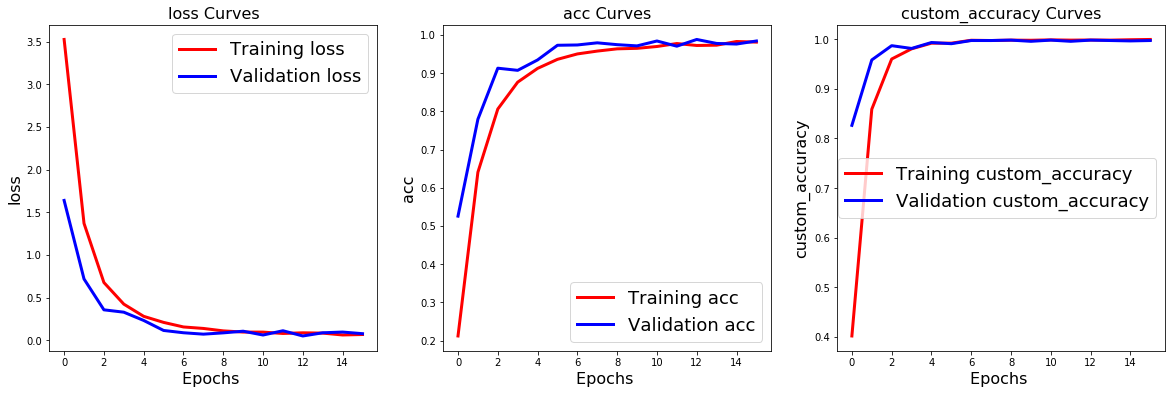

In [59]:
plt_history(history)

# Model 2 - Mobilenet transfer learning model

In [13]:
import tensorflow_hub as hub
#5s to load the model
module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2', \
                    trainable=True)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2'))
print(IMAGE_SIZE)

[128, 128]


In [14]:
FeatureVector128 = tf.keras.layers.Lambda(module, input_shape = IMAGE_SIZE+[3])
model2 = tf.keras.Sequential([FeatureVector128] )
model2.add(Dense(95, activation='softmax'))
model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model2.summary()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0316 23:33:27.061952 18148 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 95)                121695    
Total params: 121,695
Trainable params: 121,695
Non-trainable params: 0
_________________________________________________________________


In [15]:
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [17]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=3, verbose=0, mode='auto')
         
history = model2.fit(X_train128, y_train,
                    validation_data = (X_val128, y_val),
                    callbacks = [cp_earlystop],
                    epochs=50)

Train on 3750 samples, validate on 1250 samples
Epoch 1/50
3750/3750 [==============================] - 12s 3ms/step - loss: 1.3974 - acc: 0.7400 - custom_accuracy: 0.8605 - val_loss: 0.3147 - val_acc: 0.9576 - val_custom_accuracy: 0.9968
Epoch 2/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.1447 - acc: 0.9824 - custom_accuracy: 0.9992 - val_loss: 0.0915 - val_acc: 0.9896 - val_custom_accuracy: 1.0000
Epoch 3/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0492 - acc: 0.9939 - custom_accuracy: 0.9997 - val_loss: 0.0533 - val_acc: 0.9928 - val_custom_accuracy: 1.0000
Epoch 4/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0231 - acc: 0.9976 - custom_accuracy: 1.0000 - val_loss: 0.0334 - val_acc: 0.9936 - val_custom_accuracy: 1.0000
Epoch 5/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0126 - acc: 0.9992 - custom_accuracy: 1.0000 - val_loss: 0.0243 - val_acc: 0.9944 - val_custom_accuracy: 1.0000
E

In [19]:
model2.evaluate(X_test128, y_test)

1000/1000 [==============================] - 2s 2ms/step


[0.05619936080682965, 0.982, 0.999]

In [20]:
path_weights = './saved_models/model2/weights.h5'

#Note, cannot save model with this version of Tensorflow
model2.save_weights(path_weights)

# Model 3 - Resize as 1st layer of model

In [21]:
#5s to load the model
module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2', \
                    trainable=True)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2'))
print(IMAGE_SIZE)

[128, 128]


In [24]:
resize_layer = tf.keras.layers.Lambda(lambda x: tf.image.resize_images(x, (128,128)), input_shape = (100,100,3))
FeatureVector128 = tf.keras.layers.Lambda(module, input_shape = IMAGE_SIZE+[3])

model3 = tf.keras.Sequential()
model3.add(resize_layer)
model3.add(FeatureVector128)
model3.add(Dense(95, activation='softmax'))
model3.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model3.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0316 23:37:47.953455 18148 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 95)                121695    
Total params: 121,695
Trainable params: 121,695
Non-trainable params: 0
_________________________________________________________________


In [25]:
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [26]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=3, verbose=0, mode='auto')


history = model3.fit(X_train, y_train,
                     validation_data = (X_val, y_val),
                     callbacks=[cp_earlystop ],
                    epochs=30)

Train on 3750 samples, validate on 1250 samples
Epoch 1/30
3750/3750 [==============================] - 11s 3ms/step - loss: 1.4453 - acc: 0.7296 - custom_accuracy: 0.8509 - val_loss: 0.3254 - val_acc: 0.9544 - val_custom_accuracy: 0.9968
Epoch 2/30
3750/3750 [==============================] - 8s 2ms/step - loss: 0.1580 - acc: 0.9784 - custom_accuracy: 0.9987 - val_loss: 0.1159 - val_acc: 0.9800 - val_custom_accuracy: 0.9992
Epoch 3/30
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0561 - acc: 0.9920 - custom_accuracy: 1.0000 - val_loss: 0.0545 - val_acc: 0.9904 - val_custom_accuracy: 0.9992
Epoch 4/30
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0260 - acc: 0.9968 - custom_accuracy: 1.0000 - val_loss: 0.0413 - val_acc: 0.9920 - val_custom_accuracy: 0.9992
Epoch 5/30
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0153 - acc: 0.9987 - custom_accuracy: 1.0000 - val_loss: 0.0277 - val_acc: 0.9952 - val_custom_accuracy: 0.9992
E

In [27]:
model3.evaluate(X_test, y_test)

1000/1000 [==============================] - 1s 1ms/step


[0.07408162772736977, 0.978, 0.998]

In [23]:
path_weights = './saved_models/model3/weights.h5'

#Note, cannot save model with this version of Tensorflow
model3.save_weights(path_weights)

## Load a model

In [5]:
resize_layer = tf.keras.layers.Lambda(lambda x: tf.image.resize_images(x, (128,128)), input_shape = (100,100,3))
FeatureVector128 = tf.keras.layers.Lambda(module, input_shape = IMAGE_SIZE+[3])

model4 = tf.keras.Sequential()
model4.add(resize_layer)
model4.add(FeatureVector128)
model4.add(Dense(95, activation='softmax'))
model4.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','sparse_categorc])  

model4.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 15:51:06.930489  3832 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 95)                121695    
Total params: 121,695
Trainable params: 121,695
Non-trainable params: 0
_________________________________________________________________


In [14]:
model4.evaluate(X_test,y_test)

1000/1000 [==============================] - 4s 4ms/step


[5.1594472503662105, 0.004]

In [19]:
path_weights = './saved_models/model3/weights.h5'
model4.load_weights(path_weights)
model4.evaluate(X_test,y_test)

1000/1000 [==============================] - 2s 2ms/step


[0.06626675423170672, 0.979]

## Real data

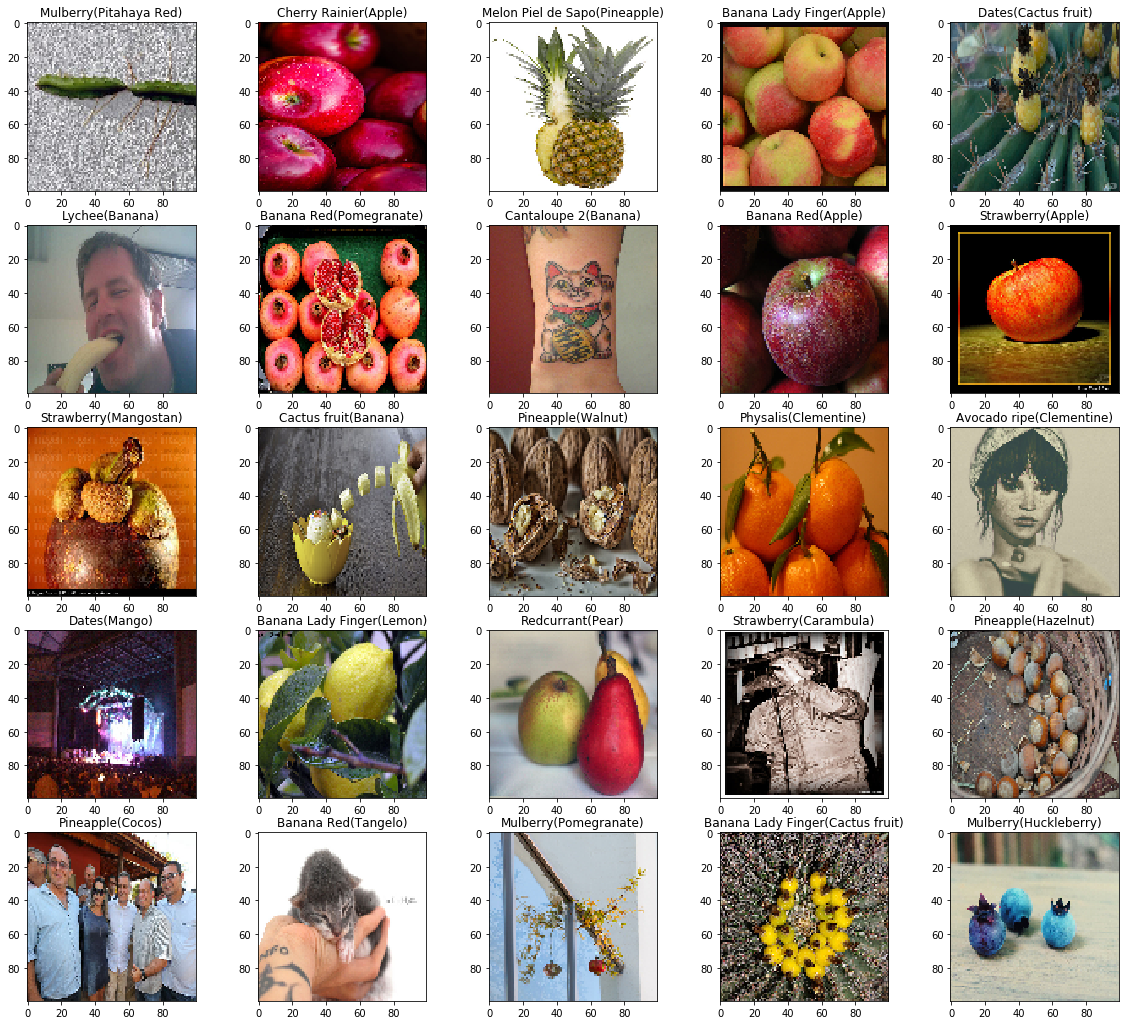

In [269]:
labels = label_encoder.inverse_transform(model.predict_classes(X_flicker))

plt.figure(figsize=(20,18))
for count, photo in enumerate(labels[:25]):
    plt.subplot(5,5, count+1)
    plt.imshow(X_flicker[count,:,:,:])
    plt.title(photo+'({})' .format(y_flicker[count]))

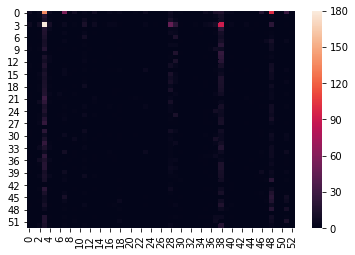

In [268]:
y_predict = convert_to_supergroup(labels)
sns.heatmap(confusion_matrix(y_flicker, y_predict))

In [271]:
print(classification_report(y_flicker, y_predict))

                precision    recall  f1-score   support

         Apple       0.23      0.02      0.03       455
       Apricot       0.00      0.00      0.00        50
       Avocado       0.00      0.00      0.00        50
        Banana       0.18      0.40      0.25       454
  Cactus fruit       0.06      0.08      0.07        50
    Cantaloupe       0.00      0.00      0.00        50
     Carambula       0.00      0.00      0.00        50
        Cherry       0.02      0.06      0.03        50
      Chestnut       0.00      0.00      0.00        50
    Clementine       0.03      0.02      0.02        50
         Cocos       0.00      0.00      0.00        50
         Dates       0.02      0.04      0.03        50
    Granadilla       0.00      0.00      0.00        50
         Grape       0.00      0.00      0.00        49
    Grapefruit       0.00      0.00      0.00        50
         Guava       0.00      0.00      0.00        50
      Hazelnut       0.00      0.00      0.00  

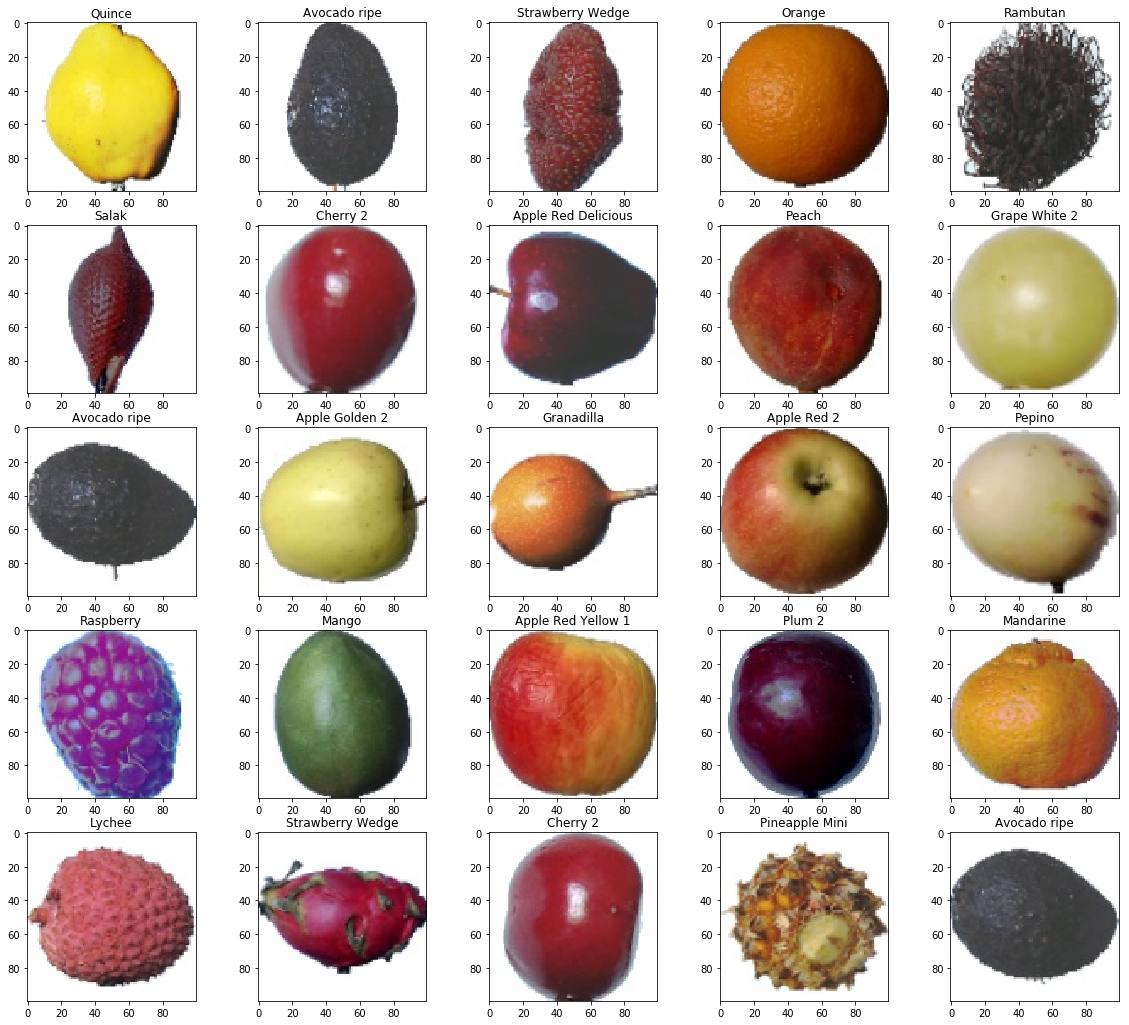

In [61]:
labels = label_encoder.inverse_transform(model.predict_classes(X_test))

plt.figure(figsize=(20,18))
for count, photo in enumerate(labels[:25]):
    plt.subplot(5,5, count+1)
    plt.imshow(X_test[count,:,:,:])
    plt.title(photo)

                     precision    recall  f1-score   support

     Apple Braeburn       1.00      0.33      0.50         6
     Apple Golden 1       0.92      0.92      0.92        12
     Apple Golden 2       0.75      0.86      0.80         7
     Apple Golden 3       0.82      1.00      0.90         9
 Apple Granny Smith       1.00      0.75      0.86         4
        Apple Red 1       1.00      0.78      0.88         9
        Apple Red 2       0.64      1.00      0.78         7
        Apple Red 3       1.00      1.00      1.00        10
Apple Red Delicious       1.00      1.00      1.00        11
 Apple Red Yellow 1       1.00      1.00      1.00         9
 Apple Red Yellow 2       1.00      1.00      1.00        10
            Apricot       1.00      0.50      0.67         6
            Avocado       1.00      1.00      1.00         7
       Avocado ripe       1.00      1.00      1.00        10
             Banana       1.00      0.50      0.67        10
 Banana Lady Finger    

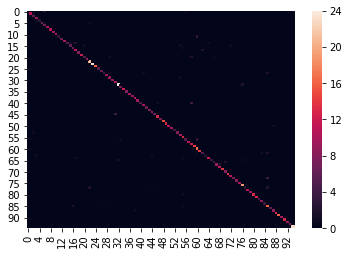

In [181]:
from sklearn.metrics import classification_report, classification, confusion_matrix
import seaborn as sns

y_true = label_encoder.inverse_transform(y_test)
y_predict = labels;

sns.heatmap(confusion_matrix(y_true, y_predict))

print(classification_report(y_true, y_predict))

# Data Augmentation code

In [30]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [31]:
model3.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=5,
                    validation_data = (X_val, y_val))

Epoch 1/5
118/117 [==============================] - 12s 104ms/step - loss: 5.8917 - acc: 0.5285 - val_loss: 3.7449 - val_acc: 0.6880
Epoch 2/5
118/117 [==============================] - 12s 99ms/step - loss: 2.3724 - acc: 0.7902 - val_loss: 1.8861 - val_acc: 0.8296
Epoch 3/5
118/117 [==============================] - 12s 99ms/step - loss: 1.4334 - acc: 0.8692 - val_loss: 1.2959 - val_acc: 0.8840
Epoch 4/5
118/117 [==============================] - 12s 98ms/step - loss: 1.0730 - acc: 0.9080 - val_loss: 1.0567 - val_acc: 0.9064
Epoch 5/5
118/117 [==============================] - 12s 99ms/step - loss: 0.9211 - acc: 0.9244 - val_loss: 0.9297 - val_acc: 0.9168


In [32]:
model3.evaluate(X_test, y_test)

1000/1000 [==============================] - 2s 2ms/step


[1.093194827687228, 0.886]

In [ ]:
plt_history(model3)

### CIFAR 100 dataset

In [90]:
from keras.datasets import cifar100

Using TensorFlow backend.


In [91]:
(X_cifar_train, y_cifar_train), (X_cifar_test, y_cifar_test) = cifar100.load_data()

169009152/169001437 [==============================] - 116s 1us/step


In [110]:
apples = X_cifar_train[(y_cifar_train==0)[:,0],:,:,:]

In [116]:
n = 500
apples_test128 = tf.image.resize_images(X_test[0:n,:], (128,128)).eval(session=sess)



In [118]:
label_encoder.inverse_transform(model2.predict_classes(apples_test128))

array(['Banana Lady Finger', 'Banana', 'Banana', 'Apricot',
       'Tomato Cherry Red', 'Mulberry', 'Tomato 4', 'Limes', 'Dates',
       'Cherry Rainier', 'Pear Monster', 'Grape Pink', 'Nectarine',
       'Cherry Rainier', 'Pear', 'Grape Pink', 'Tomato 1', 'Maracuja',
       'Cherry Wax Red', 'Tamarillo', 'Tomato Cherry Red',
       'Cherry Rainier', 'Clementine', 'Pineapple', 'Strawberry',
       'Redcurrant', 'Clementine', 'Apple Granny Smith', 'Mango',
       'Apricot', 'Tomato 2', 'Passion Fruit', 'Banana', 'Guava',
       'Chestnut', 'Apple Golden 3', 'Passion Fruit', 'Physalis',
       'Tomato 2', 'Pear Monster', 'Lemon', 'Tomato Cherry Red', 'Orange',
       'Tomato Cherry Red', 'Huckleberry', 'Apple Granny Smith',
       'Passion Fruit', 'Cherry Rainier', 'Cherry 1', 'Pear Monster',
       'Nectarine', 'Peach 2', 'Tomato Cherry Red', 'Hazelnut',
       'Huckleberry', 'Tomato 2', 'Grapefruit Pink', 'Peach Flat', 'Pear',
       'Cherry 1', 'Pitahaya Red', 'Cocos', 'Strawberry Wed

In [94]:
CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]



## Train a model on Real Data

In [70]:
#Define a model:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100,100,3)))
model5.add(Conv2D(32, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(3, 3)))
model5.add(Dropout(0.25))

model5.add(Flatten())
model5.add(Dense(264, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(95, activation='softmax'))

model5.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 264)               8651016   
_________________________________________________________________
dropout_7 (Dropout)          (None, 264)               0         
__________

In [74]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_real_train)

In [172]:
label_encoder_short = LabelEncoder()

y_flicker = label_encoder_short.fit_transform(y_flicker)
X_flicker_train, X_flicker_val, y_flicker_train, y_flicker_val = train_test_split(X_flicker, y_flicker) 


In [173]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=3, verbose=0, mode='auto')

model5.fit_generator(datagen.flow(X_flicker_train, y_flicker_train, batch_size=32),
                    steps_per_epoch=len(X_flicker_train) / 32, epochs=30,
                     callbacks = [cp_earlystop],
                    validation_data = (X_flicker_val, y_flicker_val))

Epoch 1/30
78/77 [==============================] - 19s 249ms/step - loss: 3.7616 - acc: 0.1799 - custom_accuracy: 0.3180 - val_loss: 3.4945 - val_acc: 0.2273 - val_custom_accuracy: 0.3773
Epoch 2/30
78/77 [==============================] - 6s 74ms/step - loss: 3.4261 - acc: 0.2133 - custom_accuracy: 0.3873 - val_loss: 3.4643 - val_acc: 0.2164 - val_custom_accuracy: 0.3857
Epoch 3/30
78/77 [==============================] - 6s 74ms/step - loss: 3.2385 - acc: 0.2358 - custom_accuracy: 0.4301 - val_loss: 3.3758 - val_acc: 0.1911 - val_custom_accuracy: 0.3881
Epoch 4/30
78/77 [==============================] - 6s 76ms/step - loss: 3.1048 - acc: 0.2517 - custom_accuracy: 0.4690 - val_loss: 3.2296 - val_acc: 0.2455 - val_custom_accuracy: 0.4329
Epoch 5/30
78/77 [==============================] - 6s 75ms/step - loss: 3.0049 - acc: 0.2706 - custom_accuracy: 0.4951 - val_loss: 3.7908 - val_acc: 0.2479 - val_custom_accuracy: 0.4571
Epoch 6/30
78/77 [==============================] - 6s 75ms/ste

In [174]:
history = model5.fit(X_flicker_train, y_flicker_train,
                    validation_data = (X_flicker_val, y_flicker_val),
                    callbacks = [cp_earlystop],
                    epochs=30)

Train on 2478 samples, validate on 827 samples
Epoch 1/30
2478/2478 [==============================] - 6s 2ms/step - loss: 2.4630 - acc: 0.3539 - custom_accuracy: 0.6243 - val_loss: 2.8569 - val_acc: 0.3132 - val_custom_accuracy: 0.5345
Epoch 2/30
2478/2478 [==============================] - 5s 2ms/step - loss: 2.0631 - acc: 0.4447 - custom_accuracy: 0.7385 - val_loss: 2.9978 - val_acc: 0.2878 - val_custom_accuracy: 0.5417
Epoch 3/30
2478/2478 [==============================] - 5s 2ms/step - loss: 1.5751 - acc: 0.5690 - custom_accuracy: 0.8269 - val_loss: 3.6445 - val_acc: 0.2648 - val_custom_accuracy: 0.4813
Epoch 4/30
2478/2478 [==============================] - 5s 2ms/step - loss: 1.2071 - acc: 0.6630 - custom_accuracy: 0.8858 - val_loss: 3.4525 - val_acc: 0.2866 - val_custom_accuracy: 0.5115


## For the bin